In [5]:
import netCDF4 as nc
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib.pyplot import figure, show, subplots
from matplotlib import pyplot as plt
import subprocess
import toml
import csv
from tomlkit import dumps
from tomlkit import parse
from tomlkit import inline_table
import os

In [14]:
filepath = "/Users/users/borgmann/Documents/masterproject/scripts/EVo/out/atmospheres_mole.csv"
data = np.genfromtxt(filepath,skip_header=1,delimiter=',')[:,2:]
coords = np.genfromtxt(filepath,skip_header=1,delimiter=',')[:,:2]
titles = np.genfromtxt(filepath,dtype=str,delimiter=',')[0][2:]
print(titles)
print(coords[77])
print(data[77])

['H2O' 'H2' 'O2' 'CO2' 'CO' 'CH4' 'SO2' 'H2S' 'S2' 'N2']
[2.22222222 2.44444444]
[6.75274625e-01 6.07201591e-02 2.12227850e-10 5.14385061e-02
 1.14226131e-02 2.24104227e-11 5.88019453e-02 6.86767431e-02
 7.23190037e-02 1.34640406e-03]


In [3]:
def input_volatiles(filepath,volatile_dict):

    with open(filepath, "r") as f:
        toml_str = f.read()
    doc = parse(toml_str)

    my_table = inline_table()
    for key, value in volatile_dict.items():
        my_table[key] = value
    my_table.trivia.trail = "\n"
    doc["composition"]["vmr_dict"] = my_table

    with open(filepath, "w") as f:
        f.write(dumps(doc))  # Use str() to serialize back to TOML

# dict_data = []
# for i in data[0]:
#     dict_data.append(float(i))



The latest version of Julia in the `release` channel is 1.11.5+0.x64.linux.gnu. You currently have `1.11.4+0.x64.linux.gnu` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.5+0.x64.linux.gnu and update the `release` channel to that version.
  Activating project at `/dataserver/users/formingworlds/borgmann/AGNI`


[ INFO  ] Using configuration 'LIFE_spectra' 
[ INFO  ] Setting-up a new atmosphere struct 
[ INFO  ] Loading thermodyamic data 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocating atmosphere with composition: 
[ INFO  ]       1 H2      5.08e-15 (NO_OPACITY EOS_CMS19) 
[ INFO  ]       2 CO      1.41e-05 (NO_OPACITY EOS_VDW) 
[ INFO  ]       3 CH4     1.60e-08 (NO_OPACITY EOS_VDW) 
[ INFO  ]       4 H2S     9.76e-06 (NO_OPACITY EOS_VDW) 
[ INFO  ]       5 S2      4.75e-03 (NO_OPACITY EOS_IDEAL) 
[ INFO  ]       6 SO2     9.06e-03 (NO_OPACITY EOS_VDW) 
[ INFO  ]       7 H2O     7.03e-01 (EOS_AQUA) 
[ INFO  ]       8 CO2     2.77e-01 (NO_OPACITY EOS_VDW) 
[ INFO  ]       9 O2      6.00e-03 (NO_OPACITY EOS_VDW) 
[ INFO  ] Setting T(p): dry, sat 
[ INFO  ] Solving with 'none' 
[ INFO  ]     done 
[ INFO  ] Total RT evalulations: 2 
[ INFO  ] Writing results 
[ INFO  ] Plotting results 
[ INFO  ] Deallocating memory 
[ INFO  ] Model runtime: 34.43 seconds 


The latest version of Julia in the `release` channel is 1.11.5+0.x64.linux.gnu. You currently have `1.11.4+0.x64.linux.gnu` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.5+0.x64.linux.gnu and update the `release` channel to that version.
  Activating project at `/dataserver/users/formingworlds/borgmann/AGNI`

[3689871] signal 2: Interrupt
in expression starting at /dataserver/users/formingworlds/borgmann/AGNI/agni.jl:26
_ZL15collectBitPartsPN4llvm5ValueEbbRSt3mapIS1_St8optionalIN12_GLOBAL__N_17BitPartEESt4lessIS1_ESaISt4pairIKS1_S6_EEEiRb.isra.0 at /dataserver/users/formingworlds/borgmann/.julia/juliaup/julia-1.11.4+0.x64.linux.gnu/bin/../lib/julia/libLLVM-16jl.so (unknown line)
_ZL15collectBitPartsPN4llvm5ValueEbbRSt3mapIS1_St8optionalIN12_GLOBAL__N_17BitPartEESt4lessIS1_ESaISt4pairIKS1_S6_EEEiRb.isra.0 at /dataserver/users/formingworlds/borgmann/.julia/juliaup/julia-1.11.4+0.x64.linux.gnu/bin/../lib/julia/libLLVM-16jl.so (unknown line)
_ZL15collectBi

KeyboardInterrupt: 

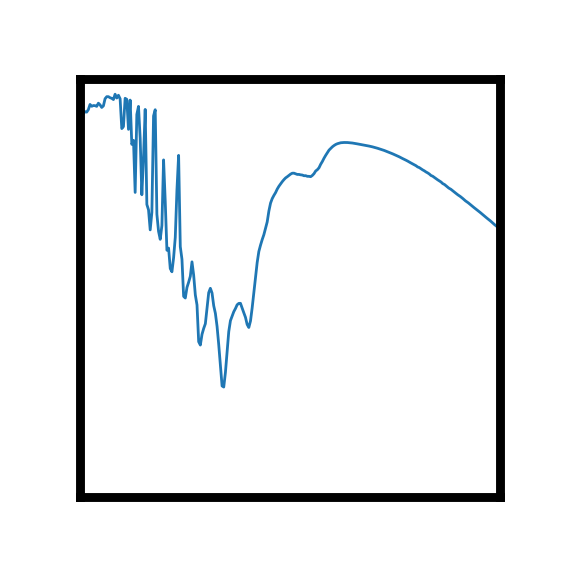

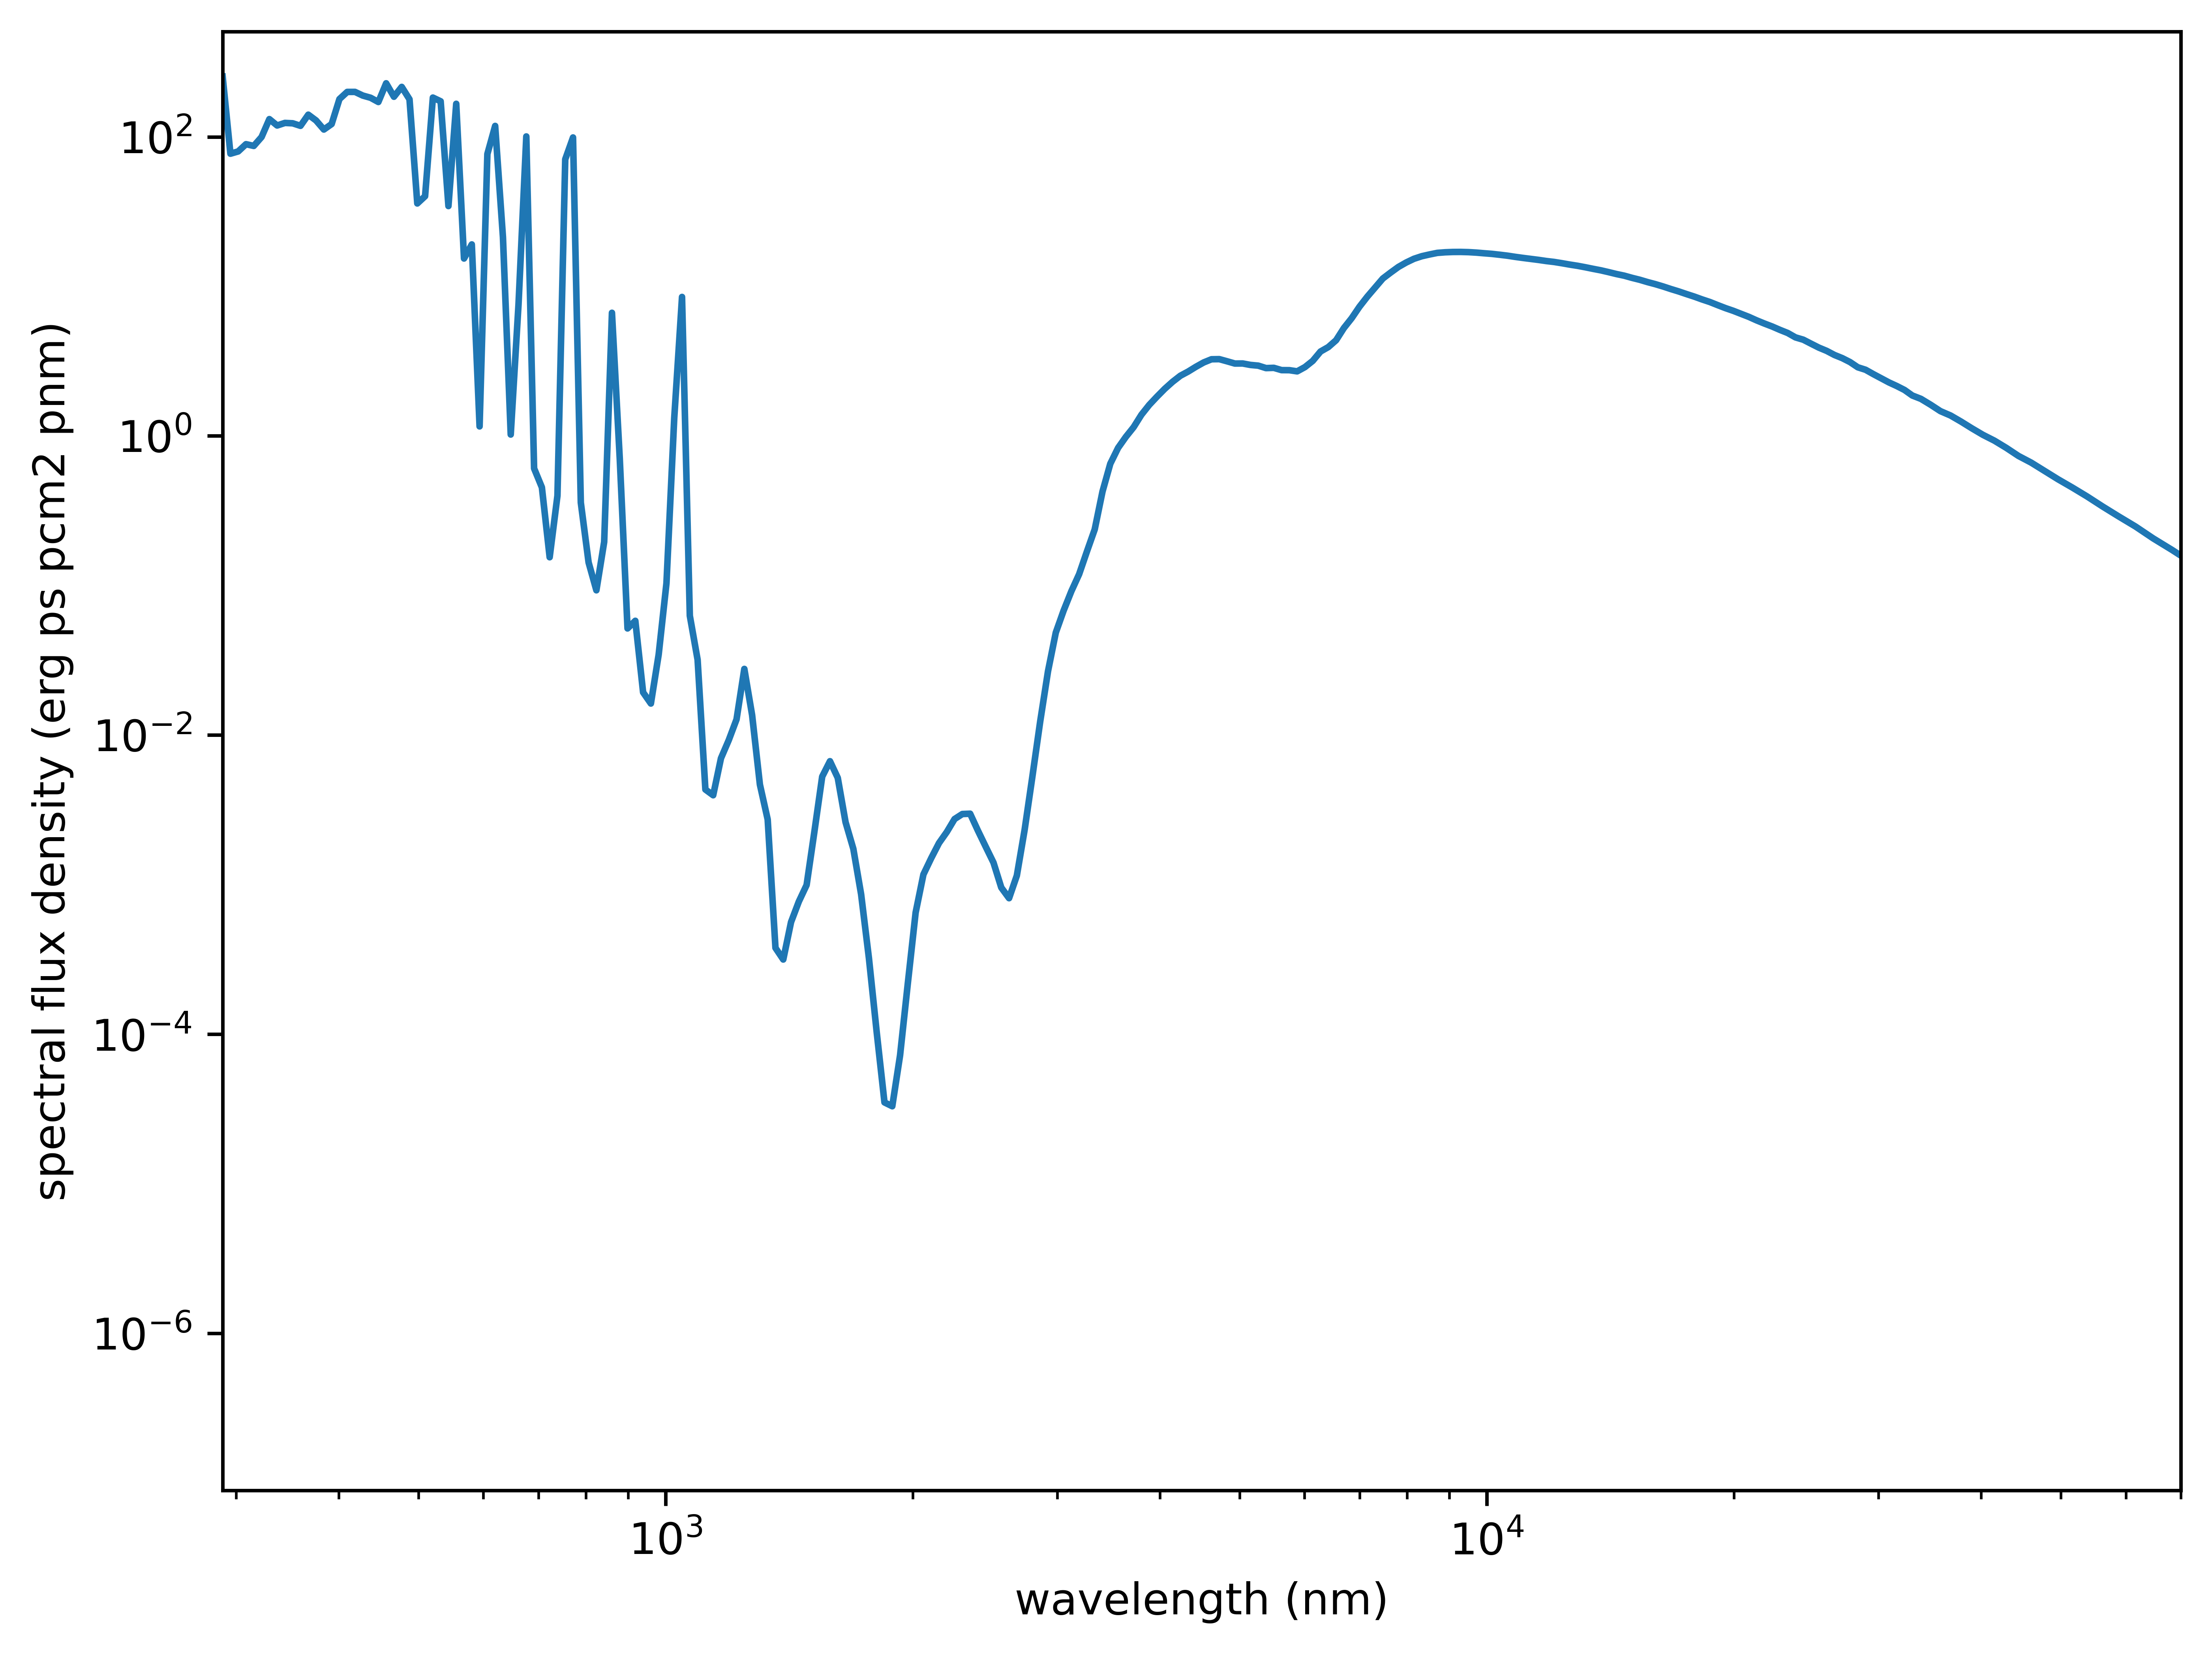

In [ ]:
#ROOT_DIR = "/dataserver/users/formingworlds/borgmann/AGNI"

def write_data(filepath,bandcenter,intensity):
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['bandcenter','intensity',])
        for i in range(len(bandcenter)):
            string = [str(bandcenter[i]),str(intensity[i])]
            writer.writerow(string)

# start rasterplot
mpl.rcParams['figure.dpi'] = 800
rasterplot = figure(figsize=(8,8))

custom_order = []
for i in range(1,11):
    #print(i)
    custom_order.append(np.arange(90+i,i-10,-10))
custom_order = np.array(custom_order).flatten()

for i in range(len(data)):
    # insert atmosphere and run AGNI
    dictionary = dict(zip(titles, data[i]))
    input_volatiles("LIFE_spectra.toml",dictionary)
    subprocess.run("export RAD_DIR='/dataserver/users/formingworlds/borgmann/AGNI/usr/SOCRATES';./agni.jl /Users/users/borgmann/Documents/masterproject/scripts/AGNI/LIFE_spectra.toml",cwd="/dataserver/users/formingworlds/borgmann/AGNI", shell=True)

    # read out emission data
    AGNI_out = "/dataserver/users/formingworlds/borgmann/AGNI/out/atm.nc"
    ds = nc.Dataset(AGNI_out)
    bandmin_data = ds['bandmin'][:]
    bandmax_data = ds['bandmax'][:]
    bandcenter = (bandmin_data + bandmax_data)/2 * 10**9
    bandwidth = (bandmax_data - bandmin_data) * 10**9
    lw_data = ds['ba_U_LW'][:]
    sw_data = ds['ba_U_SW'][:]
    bandflux = (lw_data[1, :] + sw_data[1, :]) / bandwidth * 1000

    # save image and text file
    csvname = 'out/AGNI_spectra_textfiles/AGNI_spectrum_' + str(coords[i][0]) + '_' + str(coords[i][1]) + '.csv'
    write_data(csvname, bandcenter,bandflux)

    fig = figure(figsize=(8,6))
    frame1 = fig.add_subplot(1,1,1)
    frame1.plot(bandcenter,bandflux)
    frame1.set_xlabel('wavelength (nm)')
    frame1.set_ylabel('spectral flux density (erg ps pcm2 pnm)')
    frame1.set_xscale('log')
    frame1.set_yscale('log')
    frame1.set_xlim(max(1.0e-10,min(bandcenter)), min(max(bandcenter), 70000.0))
    frame1.set_ylim(max(1.0e-10,min(bandflux)) / 2, max(bandflux) * 2)
    pngname = 'out/AGNI_spectra_images/AGNI_spectrum_' + str(coords[i][0]) + '_' + str(coords[i][1]) + '.png'
    fig.savefig(pngname)

    # plot raster
    frame = rasterplot.add_subplot(10,10,custom_order[i])
    frame.plot(bandcenter,bandflux,linewidth=0.25)
    frame.set_xlim(max(1.0e-10,min(bandcenter)), min(max(bandcenter), 70000.0))
    frame.set_ylim(max(1.0e-10,min(bandflux)) / 2, max(bandflux) * 2)
    frame.set_xscale('log')
    frame.set_yscale('log')
    frame.set_yticklabels([])
    frame.set_xticklabels([])
    frame.set_xticks([])
    frame.set_yticks([])
    frame.minorticks_off()
    rasterplot.show()
# save raster plot
for j in range(10):
    left = 0.1 + j * 0.08
    ax = rasterplot.add_axes([left, 0.075, 0.1, 0.03])  # [left, bottom, width, height]
    ax.text(0.5, 0.5, str(round(coords[j*10][0],1)), ha='center', va='center')
    ax.axis('off')

for i in range(10):
    bottom = 0.1 + (9 - i) * 0.08
    ax = rasterplot.add_axes([0.1, bottom, 0.0, 0.07])
    ax.text(0.5, 0.5, str(round(coords[-i-1][1],1)), ha='center', va='center')
    ax.axis('off')

rasterplot.show()
rasterplot.savefig('out/rasterplot.png')
mpl.rcParams['figure.dpi'] = 300

In [15]:
custom_order = []
for i in range(1,11):
    #print(i)
    custom_order.append(np.arange(90+i,i-10,-10))
custom_order = np.array(custom_order).flatten()

In [16]:
data_path = "/Users/users/borgmann/Documents/masterproject/scripts/AGNI/out/AGNI_spectra_textfiles_old"
files = [f for f in os.listdir(data_path)]
print(files)

['AGNI_spectrum_-4.0_0.5.csv', 'AGNI_spectrum_-4.0_0.7777777777777777.csv', 'AGNI_spectrum_-4.0_1.0555555555555556.csv', 'AGNI_spectrum_-4.0_1.3333333333333335.csv', 'AGNI_spectrum_-4.0_1.6111111111111112.csv', 'AGNI_spectrum_-4.0_1.8888888888888888.csv', 'AGNI_spectrum_-4.0_2.166666666666667.csv', 'AGNI_spectrum_-4.0_2.4444444444444446.csv', 'AGNI_spectrum_-4.0_2.7222222222222223.csv', 'AGNI_spectrum_-4.0_3.0.csv', 'AGNI_spectrum_-3.111111111111111_0.5.csv', 'AGNI_spectrum_-3.111111111111111_0.7777777777777777.csv', 'AGNI_spectrum_-3.111111111111111_1.0555555555555556.csv', 'AGNI_spectrum_-3.111111111111111_1.3333333333333335.csv', 'AGNI_spectrum_-3.111111111111111_1.6111111111111112.csv', 'AGNI_spectrum_-3.111111111111111_1.8888888888888888.csv', 'AGNI_spectrum_-3.111111111111111_2.166666666666667.csv', 'AGNI_spectrum_-3.111111111111111_2.4444444444444446.csv', 'AGNI_spectrum_-3.111111111111111_2.7222222222222223.csv', 'AGNI_spectrum_-3.111111111111111_3.0.csv', 'AGNI_spectrum_-2.222

In [23]:
mpl.rcParams['figure.dpi'] = 800
rasterplot = figure(figsize=(8,8))

for i in range(len(files)):
    image_path = data_path + "/" + files[i]
    bandcenter = np.genfromtxt(image_path,skip_header=1,delimiter=",")[:,0]
    bandflux = np.genfromtxt(image_path,skip_header=1,delimiter=",")[:,1]
    print(bandflux)
    frame = rasterplot.add_subplot(10,10,custom_order[i])
    frame.plot(bandcenter,bandflux,linewidth=0.25)
    #frame.set_xlim(max(1.0e-10,min(bandcenter)), min(max(bandcenter), 70000.0))
    #frame.set_ylim(max(1.0e-10,min(bandflux)) / 2, max(bandflux) * 2)
    frame.set_xscale('log')
    frame.set_yscale('log')
    frame.set_yticklabels([])
    frame.set_xticklabels([])
    frame.set_xticks([])
    frame.set_yticks([])
    frame.minorticks_off()


    #frame.axis('off')

for j in range(10):
    left = 0.1 + j * 0.08
    ax = rasterplot.add_axes([left, 0.075, 0.1, 0.03])  # [left, bottom, width, height]
    ax.text(0.5, 0.5, str(round(coords[j*10][0],1)), ha='center', va='center')
    ax.axis('off')

for i in range(10):
    bottom = 0.1 + (9 - i) * 0.08
    ax = rasterplot.add_axes([0.1, bottom, 0.0, 0.07])
    ax.text(0.5, 0.5, str(round(coords[-i-1][1],1)), ha='center', va='center')
    ax.axis('off')

rasterplot.show()
rasterplot.savefig('out/rasterplot.png')
mpl.rcParams['figure.dpi'] = 300


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7f6eb9cb8700> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 6400x6400 with 1 Axes>

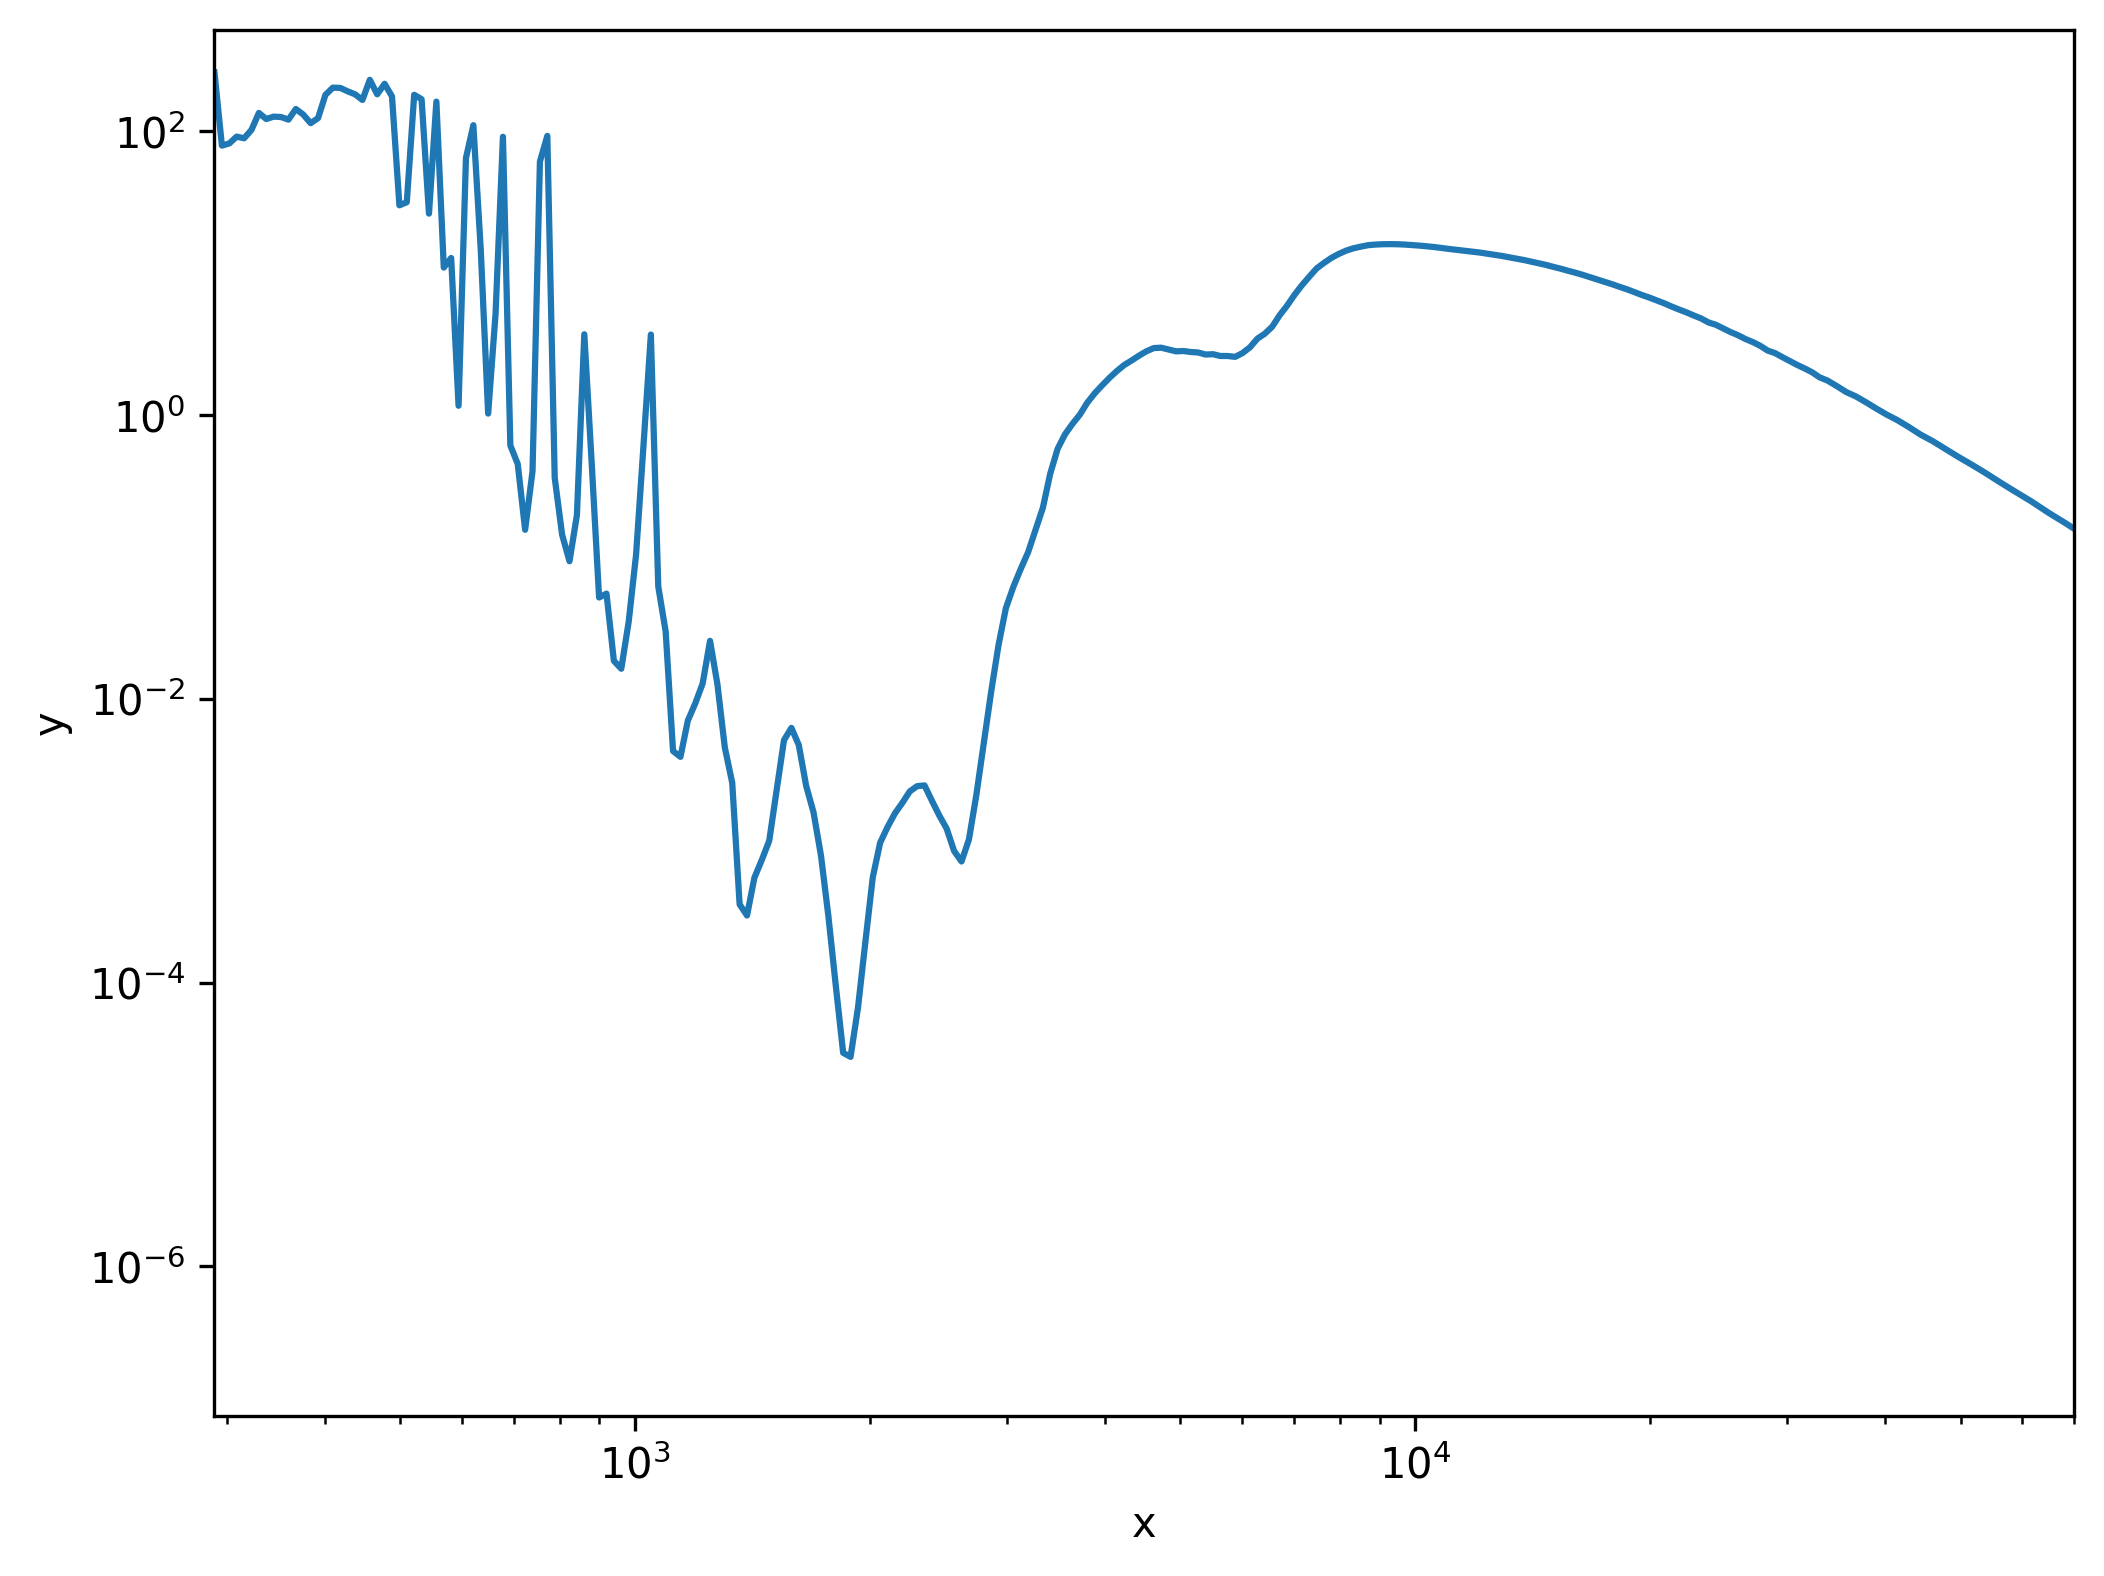

In [70]:




fig = figure(figsize=(8,6))
frame1 = fig.add_subplot(1,1,1)
frame1.plot(bandcenter,bandflux)
frame1.set_xlabel('x')
frame1.set_ylabel('y')
frame1.set_xscale('log')
frame1.set_yscale('log')

frame1.set_xlim(max(1.0e-10,min(bandcenter)), min(max(bandcenter), 70000.0))
frame1.set_ylim(max(1.0e-10,min(bandflux)) / 2, max(bandflux) * 2)

fig.show()
#fig.savefig('out/test.png')